 ## Modeling Fraud Detection

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import make_pipeline

sns.set()

### Relevant Functions

In [2]:
def plot_confusion_matrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);

In [3]:
def plot_auc_curve(fpr, tpr):
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [4]:
def feature_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    plt.figure(figsize = (8,6))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [5]:
def model_coeff(model, X):
    print("Model coefficients:\n")
    for i in range(X.shape[1]):
        print(X.columns[i], "=", model.coef_[0,i].round(4))

In [6]:
def plot_impfeatures(models, model_label, ncol=None):
    if ncol is None:
        ncol = 2
    nrow = int(np.ceil(len(models) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, model in enumerate(models):
        ax = axes.flatten()[i]
        print(model)
        importances = model.feature_importances_
        indices = np.argsort(importances)
        features = X_train.columns
        
        ax.barh(range(len(indices)), importances[indices], color='b', align='center')
        ax.set(title=model_label[i])
        ax.set(xlabel='Relative Importance')
        ax.set_yticks(range(len(indices)), [features[i] for i in indices])
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [7]:
def plot_shap_summary(models, model_label, ncol=None):
    if ncol is None:
        ncol = 2
    nrow = int(np.ceil(len(models) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8*nrow), squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, model in enumerate(models):
        ax = axes.flatten()[i]
        explainer = shap.Explainer(model.predict,X_test)
        lr_shap_values = explainer(X_test)
        #summary_plot
        shap.plots.beeswarm(lr_shap_values)
        plt.title(model_label[i])
        #ax.set(title=model_label[i])
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [8]:
def auc_score(model, y_test, X_test):
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    return auc_score

In [ ]:
def shap_values(model):
    explainer = shap.Explainer(model.predict,X_train[0:100])
    shap_values = explainer(X_test)
    return shap_values

In [9]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn import metrics

In [10]:
final_df = pd.read_csv('../clean_data/final_df.csv')
final_df.head()

,step,amount,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,281,109339.40,0,0,1,0,0,0
1,381,32426.51,0,1,0,0,0,0
2,20,55810.86,0,1,0,0,0,0
3,331,50514.72,0,0,1,0,0,0
4,182,16539.44,0,0,0,0,1,0


In [11]:
y = final_df['isFraud']
X = final_df.drop(columns = 'isFraud')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

## Model 1: Logistic Regression

### 1.1 Make Pipeline and fit

In [126]:
from sklearn.linear_model import LogisticRegression

LR_pipe = LogisticRegression()

In [127]:
LR_pipe.fit(X_train, y_train)

LogisticRegression()

In [128]:
model_name = LR_pipe

### 1.2 Hyperparameter search using GridSearchCV

In [133]:
model_name.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [134]:
grid_params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

In [135]:
lr_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)

In [136]:
lr_grid_cv.fit(X_train, y_train)


35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/skarki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [137]:
lr_grid_cv.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [141]:
lr2=LogisticRegression(C=0.001,penalty="l2")
lr2.fit(X_train,y_train)
print("score",lr2.score(X_test,y_test))

score 0.6148312119535141


In [144]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.6162410220697413

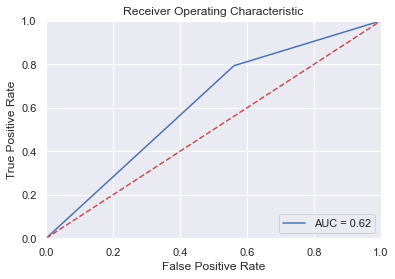

In [145]:
plot_auc_curve(fpr, tpr)

## Model 2: Random Forest

### 2.1 Make pipeline and fit

In [222]:
# Import the model
from sklearn.ensemble import RandomForestRegressor

In [223]:
# Instantiate model with 1000 decision trees
#RF_pipe = RandomForestRegressor(n_estimators = 1000, random_state = 42)
RF_pipe = RandomForestRegressor(random_state = 42)

In [224]:
# Train the model on training data
RF_pipe.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [225]:
model_name = RF_pipe

### 2.2 Hyperparameter search using GridSearchCV

In [245]:
model_name.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [246]:
grid_params = { 
    'n_estimators': [200,700, 1100],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [232]:
rf_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)

In [233]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700, 1100]})

In [234]:
score_mean = rf_grid_cv.cv_results_['mean_test_score']
score_std = rf_grid_cv.cv_results_['std_test_score']

In [235]:
rf_grid_cv.best_params_

{'max_features': 'auto', 'n_estimators': 1100}

In [236]:
rf2=RandomForestRegressor(max_features= 'auto', n_estimators= 1100)
rf2.fit(X_train,y_train)
print("score",rf2.score(X_test,y_test))

score 0.6716723254905894


In [237]:
y_pred_rf = rf2.predict(X_test)

In [238]:
score = rf2.score(X_test, y_test)
print(score)

0.6716723254905894


In [239]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rf)
metrics.auc(fpr, tpr)

0.9601263784400085

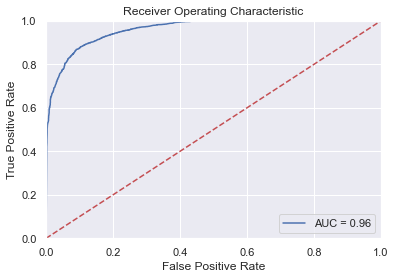

In [240]:
plot_auc_curve(fpr,tpr)

## Model 3: XGBoost

### 3.1 Make pipeline and fit

In [182]:
from xgboost import XGBRegressor

In [191]:
# xg_reg = XGBRegressor(learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg = XGBRegressor()

In [192]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [211]:
model_name = xg_reg

### 3.2 Hyperparameter search using GridSearchCV

In [200]:
model_name.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [203]:
grid_params = {'learning_rate': [0.01, 0.1, 1],
                'max_depth': [5, 10, 15], 'alpha': [10], 'n_estimators': [10, 50, 100]}

In [204]:
xg_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)

In [205]:
xg_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1,
                                    enable_categorical=False, gamma=0,
                                    gpu_id=-1, importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=8,
                                    num_parallel_tree=1, predictor='auto',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', vali

In [244]:
xg_grid_cv.best_params_

{'alpha': 10, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

## Model 4: K Nearest Neighbours

### 4.1 Make pipeline and fit

In [247]:
from sklearn.neighbors import KNeighborsClassifier

In [248]:
knn = KNeighborsClassifier()

In [249]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [250]:
model_name = knn

### 4.2 Hyperparameter search using GridSearchCV

In [251]:
model_name.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [255]:
grid_params = {}

In [256]:
xg_grid_cv = GridSearchCV(model_name, param_grid=grid_params, cv=5, n_jobs=-1)

In [257]:
xg_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1, param_grid={})

In [258]:
score_mean = xg_grid_cv.cv_results_['mean_test_score']
score_std = xg_grid_cv.cv_results_['std_test_score']

In [259]:
xg_grid_cv.best_params_

{}

In [ ]:
## Model 5: Naive Bayes

In [ ]:
## Model 6: Decision Tree

In [ ]:
## Model 7: SVM

 ## Compare different Models

In [263]:
model = [lr2, rf2, xg_reg,knn ]
model_name =['LogisticRegression', 'RandomForest', 'XGBoost', 'KNN']

### AUC Score

In [261]:
for i, name in enumerate(model):
    val = auc_score(model[i], y_test, X_test)
    print('The AUC Socre for %s is %.4f' % (model_name[i],val))

The AUC Socre for LogisticRegression is 0.6162
The AUC Socre for RandomForest is 0.9601
The AUC Socre for XGBoost is 0.9672
The AUC Socre for KNN is 0.7349


 ### Model Selection and Importance Features

RandomForestRegressor(n_estimators=1100)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


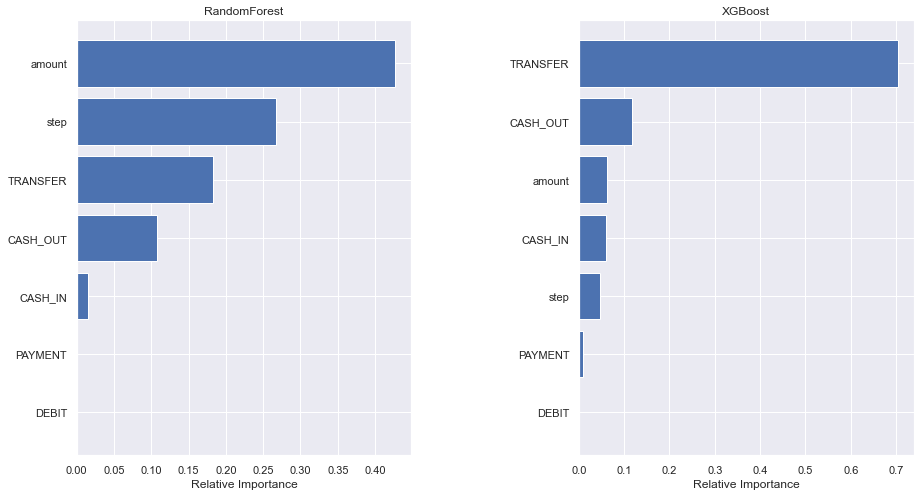

In [262]:
imp_model = [rf2,xg_reg ]
imp_model_name =['RandomForest', 'XGBoost']
plot_impfeatures(imp_model, imp_model_name)

### SHAP Analysis

In [265]:
#rf_shap_values = shap_values(rf2)
xg_shap_values = shap_values(xg_reg)

Exact explainer: 5422it [00:37, 106.80it/s]                                                                                                 


In [ ]:
shap.plots.beeswarm(rf_shap_values)

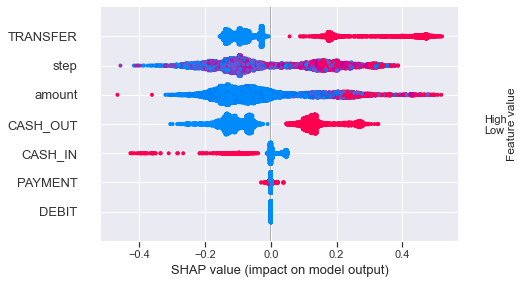

In [266]:
shap.plots.beeswarm(xg_shap_values)